In [1]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import earthaccess
import joblib
import json
import pandas as pd
from shapely.geometry import shape
import xarray as xr
from typing import Dict, Any

import data_classes


/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model
model = joblib.load('random_forest_model.pkl')

# Load scalers
X_scaler = joblib.load('X_scaler.pkl')
Y_scaler = joblib.load('Y_scaler.pkl')

In [3]:
with open('ski_areas.geojson', 'r') as f:
    ski_areas = json.load(f)


In [4]:
def is_wa_ski_site(area):
    return area['properties']['location'] and area['properties']['location']['iso3166_2'] == 'US-WA' and area['geometry']['type'] != 'Point'
wa_ski_sites = [area for area in ski_areas['features'] if is_wa_ski_site(area)]

len(wa_ski_sites)

17

In [5]:
crystal_mountain_area = [site for site in wa_ski_sites if site['properties']['name'] == 'Crystal Mountain'][0]
# crystal_mountain_area


In [6]:
# Alternative: Get bounds directly from shapely geometry
crystal_polygon = shape(crystal_mountain_area['geometry'])
crystal_bounds = crystal_polygon.bounds  # Returns (minx, miny, maxx, maxy)

print(f"\nDirect bounds: {crystal_bounds}")



Direct bounds: (-121.5089145, 46.90889530000001, -121.46718410000003, 46.9567407)


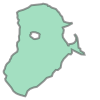

In [7]:
crystal_polygon

In [8]:
import fsspec
from pystac_client import Client
stac_api = "https://landsatlook.usgs.gov/stac-server"
collections =  ["landsat-c2ard-sr"] # "landsat-c2l3-fsca" will also be used for snow cover fraction
fs = fsspec.filesystem("s3", anon=False, requester_pays=True)
start_date, end_date = '2002-01-01', '2002-12-31'

In [9]:
client = Client.open(stac_api)
landsat_item_search = client.search(
    collections=collections,
    bbox=crystal_bounds,
    datetime=(start_date, end_date)
)

landsat_item_search.matched()

74

In [10]:
landsat_items = landsat_item_search.item_collection()

In [11]:
def process_item_parallel(args: tuple) -> Dict[str, Any]:
    """Process a single item in parallel"""
    fs, item, polygon = args
    extractor = data_classes.HLSDataExtractor(fs=fs, item=item)
    manager = data_classes.SatelliteDataManager(
        extractor=extractor
    )    
    return manager.extract_inference_data(polygon)


In [ ]:
max_workers = 8
def run_in_parallel(function, tasks):
    results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_task = {executor.submit(function, task): task for task in tasks}
        for future in as_completed(future_to_task):
            result = future.result()
            if result is not None:
                results.append(result)
    return results

In [ ]:
# %%time
# # for testing
# result = process_item_parallel((fs, landsat_items[2], crystal_polygon))

CPU times: user 3.1 s, sys: 991 ms, total: 4.09 s
Wall time: 8.99 s


In [ ]:
tasks = [(fs, item, crystal_polygon) for item in landsat_items]
results = run_in_parallel(process_item_parallel, tasks)

In [ ]:
results.head()

,time,longitude,latitude,coastal,blue,green,red,nir08,swir16,swir22,fsca
0,2002-12-20T18:43:57.151067Z,-121.508679,46.922242,NaN,21324,20549,20567,20110,12760,11439,1129
1,2002-12-20T18:43:57.151067Z,-121.508679,46.921895,NaN,21684,20335,20937,20600,12989,12176,1031
2,2002-12-20T18:43:57.151067Z,-121.508679,46.921547,NaN,21683,20978,20751,20355,13219,12422,966
3,2002-12-20T18:43:57.151067Z,-121.508679,46.921199,NaN,21861,20763,20751,20110,13219,12176,1079
4,2002-12-20T18:43:57.151067Z,-121.508331,46.923286,NaN,22400,21622,21675,21335,13678,12176,970


In [14]:
result['datetime'] = pd.to_datetime(result['time'])
result['month'] = result['datetime'].dt.month
result.loc[~result['fsca'].between(0, 1000), 'fsca'] = None

In [15]:
result.head()

,time,longitude,latitude,coastal,blue,green,red,nir08,swir16,swir22,fsca,datetime,month
0,2002-12-20T18:43:57.151067Z,-121.508679,46.922242,NaN,21324,20549,20567,20110,12760,11439,NaN,2002-12-20 18:43:57.151067+00:00,12
1,2002-12-20T18:43:57.151067Z,-121.508679,46.921895,NaN,21684,20335,20937,20600,12989,12176,NaN,2002-12-20 18:43:57.151067+00:00,12
2,2002-12-20T18:43:57.151067Z,-121.508679,46.921547,NaN,21683,20978,20751,20355,13219,12422,966.0,2002-12-20 18:43:57.151067+00:00,12
3,2002-12-20T18:43:57.151067Z,-121.508679,46.921199,NaN,21861,20763,20751,20110,13219,12176,NaN,2002-12-20 18:43:57.151067+00:00,12
4,2002-12-20T18:43:57.151067Z,-121.508331,46.923286,NaN,22400,21622,21675,21335,13678,12176,970.0,2002-12-20 18:43:57.151067+00:00,12


In [16]:

input_columns = ["red", "green", "blue", "coastal", "nir08", "swir16", "swir22", "fsca", "latitude", "longitude", "month"]
x_input_data = result[input_columns]
x_scaled = X_scaler.transform(x_input_data)


In [17]:
y_pred = model.predict(x_scaled)
y_pred

array([0.26262673, 0.26612903, 0.29576037, ..., 0.33456221, 0.3402765 ,
       0.3356682 ], shape=(8650,))

In [18]:
y_scaled = Y_scaler.inverse_transform([[pred] for pred in y_pred])
y_scaled

array([[56.98999987],
       [57.7499997 ],
       [64.18000019],
       ...,
       [72.60000026],
       [73.84000029],
       [72.84000031]], shape=(8650, 1))

In [19]:
result['snow_depth_prediction'] = y_scaled

In [22]:
result.shape

(8650, 15)

In [ ]:
# handle any overlapping pixels
reduced_pixels_df = result.groupby(['time', 'latitude', 'longitude']).agg({'snow_depth_prediction': 'mean'})

snow_depth_prediction
time                        latitude  longitude                         
2002-12-20T18:43:57.151067Z 46.909031 -121.498596              49.540000
                                      -121.498249              49.410000
                            46.909379 -121.498944              57.830000
                                      -121.498596              49.050000
                                      -121.498249              48.810000
...                                                                  ...
                            46.956314 -121.487471              66.720000
                                      -121.487123              47.690000
                                      -121.486776              48.360000
                            46.956662 -121.488514              48.740000
                                      -121.488166              62.690001

[8650 rows x 1 columns]

In [ ]:
# what we have a matrix of observations, identified by datetime and a snow depth prediction for each pixel.
# We can multiply those by the size of each pixel to get the area of snow.
# Then we can sum those up to get the total area of snow for each year.
area_of_each_pixel = 30 * 30
reduced_pixels_df['snow_volume_prediction'] = reduced_pixels_df['snow_depth_prediction'] * area_of_each_pixel
reduced_pixels_df['snow_volume_prediction']

0       51290.999885
1       51974.999732
2       57762.000168
3       52253.999831
4       57474.000139
            ...     
8645    65538.000248
8646    65556.000281
8647    65340.000237
8648    66456.000258
8649    65556.000281
Name: snow_volume_prediction, Length: 8650, dtype: float64

In [ ]:
average_for_year_month = volume_of_snow_for_hls_scene.groupby([volume_of_snow_for_hls_scene.index.year, volume_of_snow_for_hls_scene.index.month]).agg({'snow_volume_prediction': 'sum'})
average_for_year_month

In [ ]:
average_for_year_month.plot()